#### Using TensorFlow to build Neural Network model for predicting direction of Hong Kong Stock Exchange

In [585]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import sklearn
from sklearn.preprocessing import MinMaxScaler as sc
import talib

import math
import os
import datetime

import warnings; warnings.simplefilter('ignore')


#### Load in all years of data into a single DF

In [586]:
cols = ['date_time', 'open', 'high', 'low', 'close', 'volume']
patt1 = '/Users/justinsimcock/data/securities_data/hkx/' 
patt2 = 'DAT_ASCII_HKXHKD_M1_{year}.csv'
dfs = []
for y in range(2014,2019):
     dfs.append(pd.read_csv(patt1 + patt2.format(year=y), sep=';', header=-1, names = cols))

#concat dfs into one
hkx = pd.concat(dfs, axis=0)

In [587]:
hkx.isnull().any()

date_time    False
open         False
high         False
low          False
close        False
volume       False
dtype: bool

### Let's take a peek at our data

In [588]:
hkx.head()

,date_time,open,high,low,close,volume
0,20140101 201500,23408.0,23408.0,23366.0,23371.0,0
1,20140101 201600,23372.0,23389.0,23358.0,23389.0,0
2,20140101 201700,23386.0,23437.0,23386.0,23428.0,0
3,20140101 201800,23426.0,23430.0,23416.0,23422.0,0
4,20140101 201900,23420.0,23422.0,23390.0,23394.0,0


### Let's convert the date_time col to an actual date time object


In [589]:
hkx['date_time'] =  hkx['date_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d %H%M%S'))
hkx = hkx.set_index('date_time')


In [590]:
hkx.isnull().any()

open      False
high      False
low       False
close     False
volume    False
dtype: bool

#### Resample our minute data to daily data

In [591]:
hkx_daily = hkx.close.resample('1D').ohlc()
hkx_daily = hkx_daily.dropna()

#### Now that we have daily candles let's have a look at what the whole time series looks like

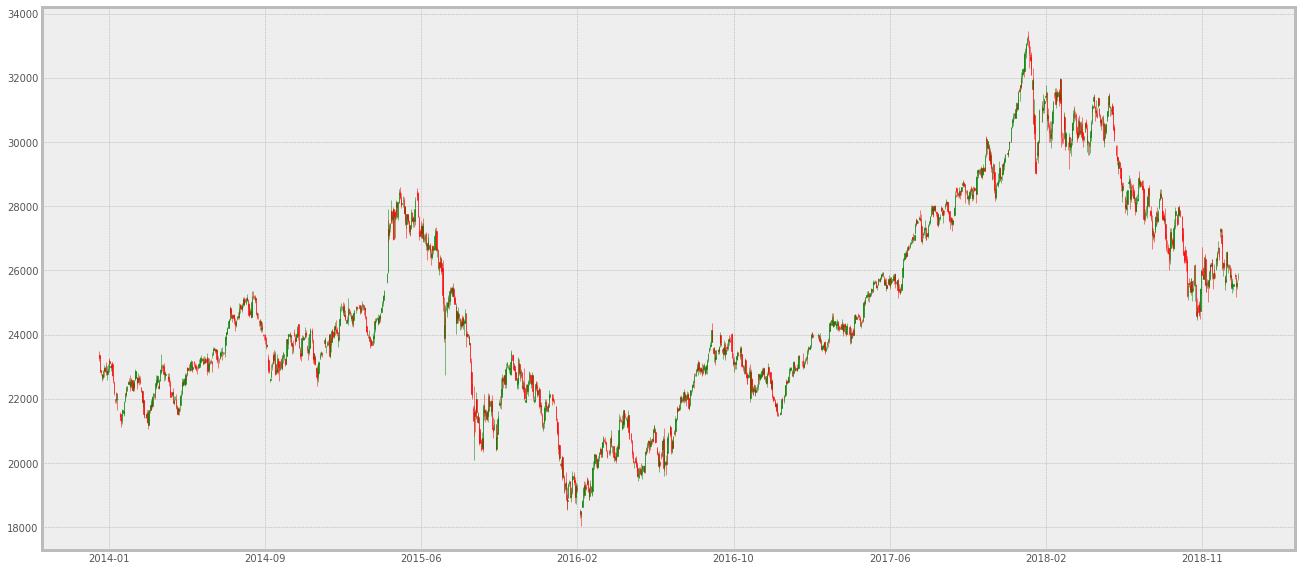

In [592]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import style
style.use('bmh')

f1, ax = plt.subplots(figsize = (20,10))

hkx_daily['date_time'] = mdates.date2num(hkx_daily.index.to_pydatetime())

ohlc = hkx_daily[['date_time', 'open', 'high', 'low','close']].copy()

candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

#### Let's generate some features. We could come up with many more features.


In [593]:
#drop the date_time col used for plotting candles
df = hkx_daily.drop(columns='date_time')
df['h-l'] = df['high'] - df['low']
df['o-c'] = df['open'] - df['close']
df['3day_ma'] = df.close.shift(1).rolling(window=3).mean()
df['10day_ma'] = df.close.shift(1).rolling(window=10).mean()
df['30day_ma'] = df.close.shift(1).rolling(window=30).mean()
df['5d_std'] = df.close.rolling(window=5).std()


#define out target variable
df['return'] = np.where(df.close.shift(-1) > df.close, 1, 0)
df = df.dropna()

#We only want the columns with features. We will remove the open, high, low, close, columns
feature_matrix = df.iloc[:,4:]

In [594]:
feature_matrix.head()


,h-l,o-c,3day_ma,10day_ma,30day_ma,5d_std,return
date_time,,,,,,,
2014-02-07,205.0,-53.0,21399.333333,21798.7,22540.433333,138.804899,0
2014-02-09,111.0,-11.0,21503.333333,21746.0,22486.266667,147.652294,1
2014-02-10,455.0,-313.0,21589.000000,21707.9,22442.566667,213.974999,1
2014-02-11,256.0,-198.0,21714.666667,21700.5,22411.566667,257.285250,1
2014-02-12,260.0,1.0,21877.000000,21696.2,22394.566667,270.808604,1


### Perform train test split with 80% test data and 20% train data


In [595]:
n = feature_matrix.shape[0]
p = feature_matrix.shape[1]

data = feature_matrix.values


train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = data[np.arange(train_start, train_end),:]
data_test = data[np.arange(test_start, test_end), :]

### Scale the data
* Some activation functions are only defined in the range -1,1 (tan) or 0, 1 (sigmoid)

In [596]:
#We need to scale the data
#Some activation functions are only defined in the range -1,1 (tan) or 0, 1 (sigmoid)

scaler = sc(feature_range=(-1,1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)


X_train = data_train[:, 0:-1]
y_train = data_train[:,-1]

X_test = data_test[:, 0:-1]
y_test = data_test[:, -1]

In [597]:
data_test.shape

(295, 7)

### Initialize TF session

In [598]:
net = tf.InteractiveSession()

### Each of the n_features will be fed into the neurons at each layer of the network

In [599]:

n_features = X_train.shape[1]

# num neurons for each layer
# these number of neurons are arbitrary

n_neurons_1 = 512
n_neurons_2 = 256
n_neurons_3 = 128

### We need to define what the network topology looks like from the input to output
* This requires initializing placeholder data structures in the shape of our input and output data
* We must also initialize data structures for our weights and biases that will be propogated through the network

In [600]:
#Set up placeholders and Variables
#placeholders are used to store input and target data in the graph
#Variables are used to store data that will change in the graph (weights and biases)

X = tf.placeholder(dtype=tf.float32, shape=[None, n_features])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode='fan_avg', distribution='uniform', scale=sigma)
bias_initializer = tf.zeros_initializer()

### Initialize the hidden layers of weights and biases

* Each layers weights will be reduced at each step
* Our output layer will be one set of weights and a set of biases

In [601]:
#Hidden Layers

weights_hidden_1 = tf.Variable(weight_initializer([n_features, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

weights_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

weights_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

#Output layers

W_output = tf.Variable(weight_initializer([n_neurons_3, 1]))
bias_output = tf.Variable(bias_initializer([1]))



### Specify the network architecture and the activation function to be run on each layer

In [602]:


hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, weights_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, weights_hidden_3), bias_hidden_3))

#network output
output_layer = tf.transpose(tf.add(tf.matmul(hidden_3, W_output), bias_output))
                            
                            
#cost function used to measure deviation from predicted and actual
mse = tf.reduce_mean(tf.squared_difference(output_layer, Y))


#optimizer is necessary during the adjustment of the weights and bias variables during training
#computes gradients that indicate direction of weights and biases need to be changed to minimize cost function
#Adaptive Moment Estimation: ADAM Optimizer is a type of stochastic gradient descent
opt = tf.train.AdamOptimizer().minimize(mse)

net.run(tf.global_variables_initializer())

### Mini batch train our network

* Mini-batch training is a composite of SGD and batch training
* SGD gives us more assurance that we have not settled at a local minimun
    * SGD is evaluating each sample one at a time so it takes longer 
* Batch training is taking the gradient for the entire dataset and can get you stuck in saddle point

In [603]:
### Train network with mini batches


# Now we need to fit the neural network that we have created to our train datasets. 
# After having defined the placeholders, variables, initializers, 
# cost functions and optimizers of the network, the model needs to be trained. 
# Usually, this is done by mini batch training. During mini batch training
# random data samples of n = batch_size are drawn from the training data and 
# fed into the network. The training dataset gets divided into n / batch_size batches that 
# are sequentially fed into the network. At this point the placeholders X and Y come into
# play. They store the input and target data and present them to the network as inputs and targets.
# A sampled data batch of X flows through the network until it reaches the output layer. 
# There, TensorFlow compares the models predictions against the actual observed targets 
# Y in the current batch. Afterwards, TensorFlow conducts an optimization step and 
# updates the networks parameters, corresponding to the selected learning scheme. 
# After having updated the weights and biases, the next batch is sampled and the
# process repeats itself. The procedure continues until all batches have been 
# presented to the network. One full sweep over all batches is called an epoch.
# The training of the network stops once the maximum number of epochs is 
# reached or another stopping criterion defined by the user applies



batch_size = 32
epochs = 50
for e in range(epochs):
    sh = np.random.permutation(np.arange(len(y_train))) 
    X_train = X_train[sh]
    y_train = y_train[sh]
    for i in range(0, len(y_train)// batch_size):
        start = i * batch_size
        batch_x = X_train[start: start + batch_size]
        batch_y = y_train[start: start + batch_size]        
        
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
        
        


### Now let's make predictions with our network

In [604]:


pred = net.run(output_layer, feed_dict={X: X_test})
y_pred = pred[0]
y_pred = pred[0] > 0.5


dataset = df.copy()
dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
trade_dataset = dataset.dropna()

#### We need to set some new column values to evaluate the performance of our strategy

In [605]:
trade_dataset['tomorrow_log_returns'] = 0
trade_dataset['tomorrow_log_returns'] = np.log(trade_dataset['close']/trade_dataset['close'].shift(1))


trade_dataset['tomorrow_log_returns'] = trade_dataset.tomorrow_log_returns.shift(-1)

trade_dataset['strategy_returns'] = 0
#if our prediction is True, we are long, otherwise we are short
trade_dataset.loc[:,'strategy_returns'] = np.where(trade_dataset['y_pred'] == True, 
                                                 trade_dataset['tomorrow_log_returns'],
                                                 -trade_dataset['tomorrow_log_returns'])

trade_dataset['cum_market_returns'] = np.cumsum(trade_dataset.tomorrow_log_returns)
trade_dataset['cum_strategy_returns'] = np.cumsum(trade_dataset.strategy_returns)

In [609]:
trade_dataset['cum_strategy_returns'][-2]

0.16759377177092744

### Let's visualize how our strategy did

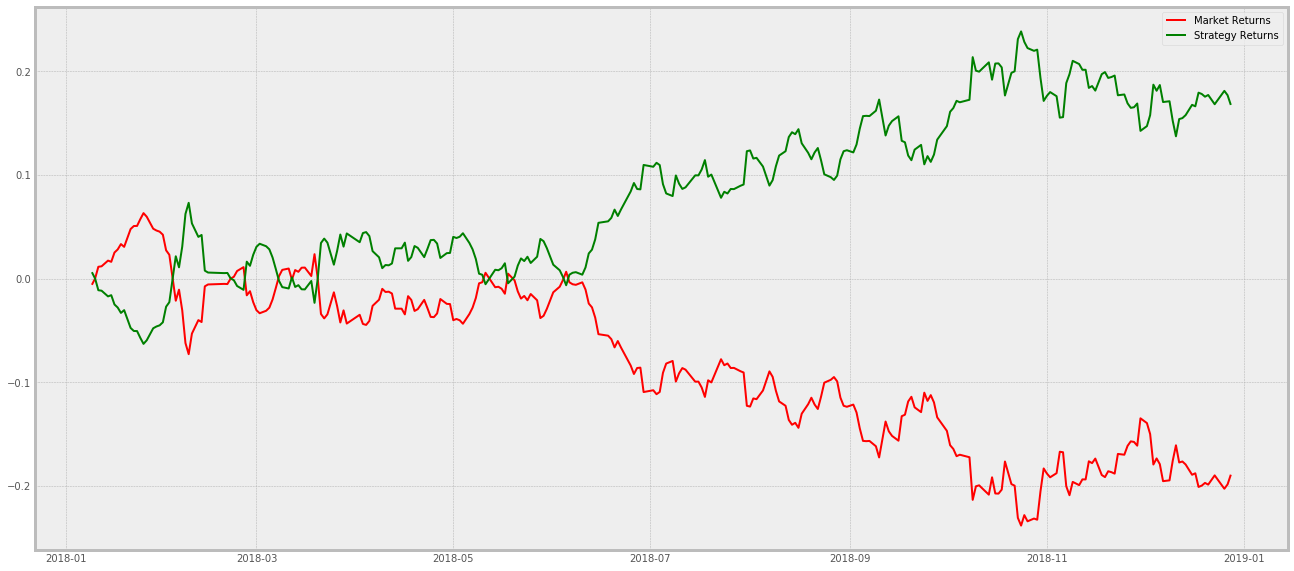

In [606]:
plt.figure(figsize=(20,10))
plt.plot(trade_dataset['cum_market_returns'], color='red', label='Market Returns')
plt.plot(trade_dataset['cum_strategy_returns'], color='green', label='Strategy Returns')
plt.legend()
plt.show()

### What about for 2019? Q4 2018 and Q1 2019 were totally opposite markets

In [578]:
###Let's set up a new testing data

cols = ['date_time', 'open', 'high', 'low', 'close', 'volume']
patt1 = '~/data/securities_data/hkx/DAT_ASCII_HKXHKD_M1_20190{m}.csv' 
dfs_m = []
for m in range(1,7):
     dfs_m.append(pd.read_csv(patt1.format(m=m), sep=';', header=-1, names = cols))
m_test = pd.concat(dfs_m)

In [579]:
m_test.head()

,date_time,open,high,low,close,volume
0,20190101 201500,25808.670,25819.17,25730.769,25732.270,0
1,20190101 201600,25731.770,25746.27,25726.769,25742.269,0
2,20190101 201700,25744.270,25745.27,25698.870,25715.870,0
3,20190101 201800,25713.869,25719.37,25698.369,25699.870,0
4,20190101 201900,25699.370,25699.37,25666.369,25685.370,0


### Set up features

In [580]:
m_test['date_time'] = m_test['date_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d %H%M%S'))
m_test = m_test.set_index('date_time')
hkx_daily_2019 = m_test.close.resample('1D').ohlc()
hkx_daily_2019 = hkx_daily_2019.dropna()

df_2019 = hkx_daily_2019
df_2019['h-l'] = df_2019['high'] - df_2019['low']
df_2019['o-c'] = df_2019['open'] - df_2019['close']
df_2019['3day_ma'] = df_2019.close.shift(1).rolling(window=3).mean()
df_2019['10day_ma'] = df_2019.close.shift(1).rolling(window=10).mean()
df_2019['30day_ma'] = df_2019.close.shift(1).rolling(window=30).mean()
df_2019['5d_std'] = df_2019.close.rolling(window=5).std()


#define out target variable
df_2019['return'] = np.where(df_2019.close.shift(-1) > df_2019.close, 1, 0)
df_2019 = df_2019.dropna()
feature_matrix = df_2019.iloc[:,4:]

data_test_2019 = feature_matrix.values
data_test_2019 = scaler.transform(data_test_2019)


X_test_2019 = data_test_2019[:, 0:-1]
y_test_2019 = data_test_2019[:, -1]

### Make predictions with our network

In [581]:
pred_2019 = net.run(output_layer, feed_dict={X: X_test_2019})

In [582]:
len(df_2019)

114

In [583]:
len(y_pred_2019)

114

### Evaluate what would have happened with our predictions

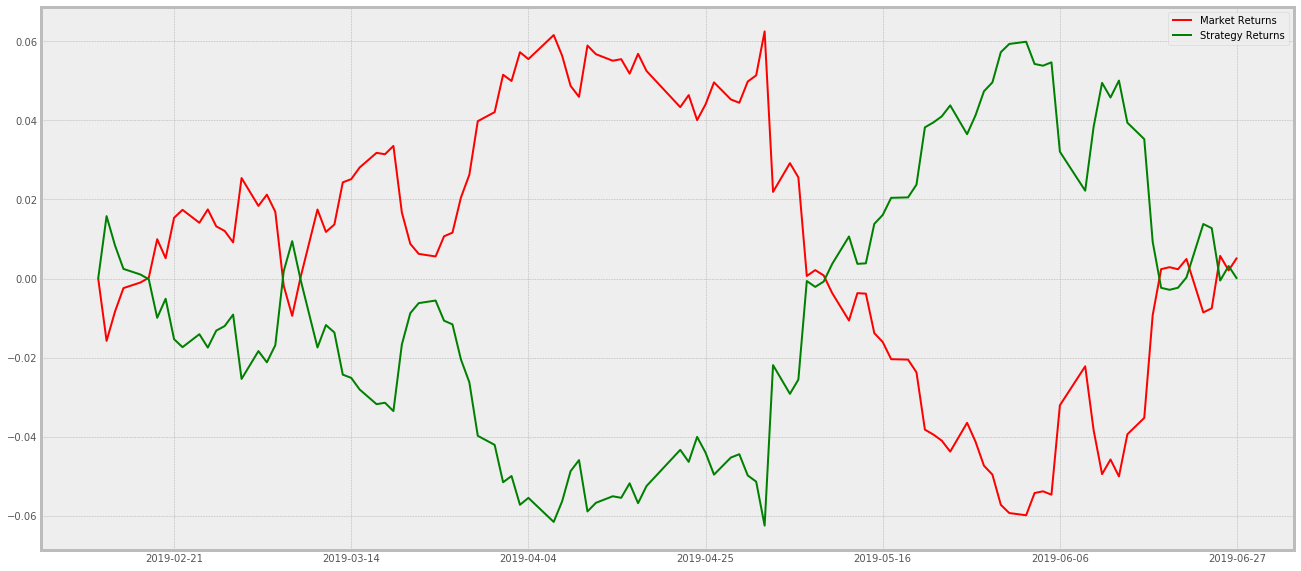

In [610]:
y_pred_2019 = pred_2019[0] > 0.5


df_2019['y_pred'] = y_pred_2019
#this is the prediction for the test period
trade_dataset_2019 = df_2019.dropna()



trade_dataset_2019['tomorrow_log_returns'] = 0
trade_dataset_2019['tomorrow_log_returns'] = np.log(trade_dataset_2019['close']/trade_dataset_2019['close'].shift(1))
trade_dataset_2019['tomorrow_log_returns'] = trade_dataset_2019.tomorrow_log_returns.shift(-1)


trade_dataset_2019['strategy_returns'] = 0
#if our prediction is True, we are long, otherwise we are short
trade_dataset_2019.loc[:,'strategy_returns'] = np.where(trade_dataset_2019['y_pred'] == True, 
                                                 trade_dataset_2019['tomorrow_log_returns'],
                                                 -trade_dataset_2019['tomorrow_log_returns'])


trade_dataset_2019['cum_market_returns'] = np.cumsum(trade_dataset_2019.tomorrow_log_returns)
trade_dataset_2019['cum_strategy_returns'] = np.cumsum(trade_dataset_2019.strategy_returns)


plt.figure(figsize=(20,10))
plt.plot(trade_dataset_2019['cum_market_returns'], color='red', label='Market Returns')
plt.plot(trade_dataset_2019['cum_strategy_returns'], color='green', label='Strategy Returns')
plt.legend()
plt.show()

### It looks like our network does good in bear markets and not good in bullish periods